# M03. Predict PAs
- This predicts the outcome of plate appearances
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Created: 4/19/2024
- Updated: 6/4/2025

Consider: 
- imputed starter, imputed reliever, unimputed starter, unimputed reliever variables
- Using batter woba and pitcher woba to determine quantiles, not projected

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Functions.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"
%run "U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Data

##### Park x Weather Factors

In [3]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Park and Weather Factors.csv"))

Choose WFX
- _unadj: predicted based on weather / predicted based on batted ball <br>
- _adj: average of actual rates in similarly predicted games / predicted based on batted ball

In [4]:
wfx_type = 'adj'
for event in events_list:
    multiplier_df[f'{event}_wfx_l'] = multiplier_df[f'{event}_wfx_{wfx_type}_l'].copy()
    multiplier_df[f'{event}_wfx_r'] = multiplier_df[f'{event}_wfx_{wfx_type}_r'].copy()

##### Plate Appearances

In [5]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "Final Dataset.csv"))

##### Steamer

In [6]:
steamer_hitters_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_hitters_weekly_log.csv"), encoding='iso-8859-1')

In [7]:
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')

### Clean

##### MLB Stats API

In [8]:
complete_dataset = complete_dataset[~complete_dataset[batter_inputs].isin([np.inf, -np.inf]).any(axis=1)]
complete_dataset = complete_dataset[~complete_dataset[pitcher_inputs].isin([np.inf, -np.inf]).any(axis=1)]

Scale

In [9]:
%%time
complete_dataset[batter_inputs] = scale_batter_stats.transform(complete_dataset[batter_inputs])
complete_dataset[pitcher_inputs] = scale_pitcher_stats.transform(complete_dataset[pitcher_inputs])

CPU times: total: 2.2 s
Wall time: 2.2 s


##### Steamer

Clean

In [10]:
steamer_hitters_df2 = clean_steamer_hitters(steamer_hitters_df)
steamer_hitters_df2.dropna(subset=batter_stats_fg, inplace=True)

Scale

In [11]:
steamer_hitters_df2[batter_stats_fg] = scale_batter_stats_steamer.transform(steamer_hitters_df2[batter_stats_fg])

Read in pitchers

Clean

In [12]:
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

Scale

In [13]:
steamer_pitchers_df2[pitcher_stats_fg] = scale_pitcher_stats_steamer.transform(steamer_pitchers_df2[pitcher_stats_fg])

##### Merge

Format dates

In [14]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
complete_dataset['date_time_copy'] = complete_dataset['date_time'].copy()
steamer_hitters_df2['date_time'] = pd.to_datetime(steamer_hitters_df2['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

steamer_hitters_df2.rename(columns={'mlbamid': 'batter'}, inplace=True)
steamer_pitchers_df2.rename(columns={'mlbamid': 'pitcher'}, inplace=True)

Sort to prep for merge

In [15]:
complete_dataset.sort_values('date_time', inplace=True)
steamer_hitters_df2.sort_values('date_time', inplace=True)
steamer_pitchers_df2.sort_values('date_time', inplace=True)

Drop unnecessary columns

In [16]:
steamer_hitters_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)
steamer_pitchers_df2.drop(columns=['date', 'firstname', 'lastname', 'steamerid'], inplace=True)

Remove missing pitchers (occurs occassionally in 2014)

In [17]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['pitcher'].isna()].reset_index(drop=True)

Set data types

In [18]:
complete_dataset['batter'] = complete_dataset['batter'].astype(int).astype(str)
complete_dataset['pitcher'] = complete_dataset['pitcher'].astype(int).astype(str)
steamer_hitters_df2['batter'] = steamer_hitters_df2['batter'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['pitcher'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [19]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_hitters_df2,
    on='date_time',
    by='batter',
    direction='backward'
)
# Correct datetime (might be unnecessary, but I'm not sure which date_time it takes after the merge)
complete_merged_df['date_time'] = complete_merged_df['date_time_copy'].copy()

complete_merged_df = pd.merge_asof(
    complete_merged_df,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher',
    direction='backward'  
)

Merge WFX

In [20]:
complete_merged_df = pd.merge(complete_merged_df, multiplier_df, on=['gamePk', 'date', 'venue_id'], how='left')

##### Impute

For players with insufficient sample sizes, stats are imputed

Option 1: Steamer

In [21]:
# # First, remove from dataset if ever missing FG/Steamer stats
# complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
# complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

# # Add hands to use in imputation
# batter_stats_fg_imp = batter_stats_fg + ['b_L', 'p_L', 'imp_b']
# pitcher_stats_fg_imp = pitcher_stats_fg + ['b_L', 'p_L', 'imp_p']

# ### Batters
# # Use Steamer stats to predict API/Statcast stats for those with limited samples
# batter_predictions = impute_batter_stats.predict(complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_stats_fg_imp])

# # Impute inputs with limited sample size with predicted values
# complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = batter_predictions

# ### Pitchers
# # Use Steamer stats to predict API/Statcast stats for those with limited samples
# pitcher_predictions = impute_pitcher_stats.predict(complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_stats_fg_imp])

# # Impute inputs with limited sample size with predicted values
# complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = pitcher_predictions

Option 2: Middle

In [22]:
# # First, remove from dataset if ever missing FG/Steamer stats
# complete_merged_df = complete_merged_df[~complete_merged_df['b1_rate'].isna()]
# complete_merged_df = complete_merged_df[~complete_merged_df['H9'].isna()]

# # Instead of imputing, just weighting with 0s
# complete_merged_df[batter_inputs].fillna(0.0, inplace=True)
# complete_merged_df[pitcher_inputs].fillna(0.0, inplace=True)

# # Calculate the weighted average for each column in pitcher_stats
# # Could be simplified, but I wanted to show the steps
# # Weighted average of provided value and 0. PAs and 50-PAs are weights. 
# for col in batter_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_b'] + 0.0 * (50-complete_merged_df['pa_b']))/50

# # Calculate the weighted average for each column in pitcher_stats
# for col in pitcher_inputs:
#     complete_merged_df[col] = (complete_merged_df[col] * complete_merged_df['pa_p'] + 0.0 * (50-complete_merged_df['pa_p']))/50

Option 3: 0s

In [23]:
# model_dataset.groupby(['b_L'])[['to_left_b_long', 'to_middle_b_long', 'to_right_b_long']].mean()
# model_dataset.groupby(['p_L'])[['to_left_p_long', 'to_middle_p_long', 'to_right_p_long']].mean()

In [24]:
complete_merged_df.loc[complete_merged_df['pa_b'] < 40, batter_inputs] = 0
complete_merged_df.loc[complete_merged_df['pa_p'] < 40, pitcher_inputs] = 0

# Batter tendencies
complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == False), ['to_left_b', 'to_left_b_long']] = -0.283467
complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == True), ['to_left_b', 'to_left_b_long']] = -0.543105

complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == False), ['to_middle_b', 'to_middle_b_long']] = -0.171325
complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == True), ['to_middle_b', 'to_middle_b_long']] = -0.222317

complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == False), ['to_right_b', 'to_right_b_long']] = -0.499793
complete_merged_df.loc[(complete_merged_df['pa_b'] < 40) & (complete_merged_df['b_L'] == True), ['to_right_b', 'to_right_b_long']] = -0.191897

# Pitcher tendencies
complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == False), ['to_left_p', 'to_left_p_long']] = -0.399969
complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == True), ['to_left_p', 'to_left_p_long']] = -0.331084

complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == False), ['to_middle_p', 'to_middle_p_long']] = -0.188469
complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == True), ['to_middle_p', 'to_middle_p_long']] = -0.186767

complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == False), ['to_right_p', 'to_right_p_long']] = -0.341691
complete_merged_df.loc[(complete_merged_df['pa_p'] < 40) & (complete_merged_df['p_L'] == True), ['to_right_p', 'to_right_p_long']] = -0.423187


complete_merged_df[batter_stats_fg] = complete_merged_df[batter_stats_fg].fillna(0)
complete_merged_df[pitcher_stats_fg] = complete_merged_df[pitcher_stats_fg].fillna(0)

### Select Data

Drop early observations

In [25]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2015-07-01']

Drop atypical events

In [26]:
complete_merged_df = complete_merged_df.query('eventsModel != "Cut"')

Drop observations from inactive parks

In [27]:
active_parks = list(team_map['VENUE_ID'].astype(int))
complete_merged_df = complete_merged_df[complete_merged_df['venue_id'].astype(int).isin(active_parks)]

### Select Variables

Batter Inputs

In [28]:
batter_input_list = batter_inputs

Pitcher Inputs

In [29]:
pitcher_input_list = pitcher_inputs

Hand Inputs

In [30]:
hand_input_list = ['p_L', 'b_L']

Imputation Inputs

In [31]:
imp_input_list = ['imp_b', 'imp_p']

Starter Input(s)

In [32]:
starter_input_list = ['starter']

Cumulative Inning Inputs

In [33]:
cumulative_inning_input_list = [col for col in complete_merged_df.columns if col.endswith("_inning")]

In [34]:
cumulative_inning_input_list.remove('rbi_inning')

Cumulative Game Inputs

In [35]:
cumulative_game_input_list = [col for col in complete_merged_df.columns if col.endswith("_game")]

In [36]:
cumulative_game_input_list.remove('rbi_game')

Game State Inputs

In [37]:
complete_merged_df['winning'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore']).astype(int)
complete_merged_df['winning_big'] = (complete_merged_df['preBatterScore'] > complete_merged_df['prePitcherScore'] + 3).astype(int)

In [38]:
game_state_input_list = ['onFirst', 'onSecond', 'onThird', 'top', 'score_diff', 'prePitcherScore', 'preBatterScore', 'winning', 'winning_big', 'times_faced']

Inning Inputs

In [39]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning'] >= 11).astype(int)

In [40]:
inning_input_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]

Out Inputs

In [41]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_pre'] == out).astype(int)

In [42]:
out_input_list = ['outs_0', 'outs_1', 'outs_2']

Venue Inputs

In [43]:
complete_merged_df['venue_id2'] = complete_merged_df['venue_id'].copy()
complete_merged_df = pd.get_dummies(complete_merged_df, columns=['venue_id2'], prefix='venue')

In [44]:
venue_input_list = [col for col in complete_merged_df.columns if col.startswith("venue_") and col != "venue_id" and col != "venue_name"]

Multiplier Inputs

In [45]:
for event in events_list:
    # Assign multiplier for their batSide
    complete_merged_df[f'{event}_wfx'] = np.where(complete_merged_df['batSide'] == "L", complete_merged_df[f'{event}_wfx_l'], 
                                                                                        complete_merged_df[f'{event}_wfx_r'])

In [46]:
multiplier_input_list = [f'{event}_wfx' for event in events_list]

Imputation and starter interactions

In [47]:
complete_merged_df['imputed_starter'] = complete_merged_df['imp_p'] * complete_merged_df['starter']
complete_merged_df['imputed_reliever'] = complete_merged_df['imp_p'] * (complete_merged_df['starter'] == 0).astype(int)
complete_merged_df['unimputed_starter'] = (complete_merged_df['imp_p'] == 0).astype(int) * complete_merged_df['starter']
complete_merged_df['unimputed_reliever'] = (complete_merged_df['imp_p'] == 0).astype(int) * (complete_merged_df['starter'] == 0).astype(int)

In [48]:
imp_starter_input_list = ['imputed_starter', 'imputed_reliever', 'unimputed_starter', 'unimputed_reliever']

Inputs

In [49]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + venue_input_list + multiplier_input_list

Outputs

In [50]:
output_list = ['is_out', 'eventsModel']

Other variables

In [51]:
additional_list = ['pa_b', 'pa_p', 'year', 'date', 'gamePk', 'atBatIndex', 'venue_id', 'batterName', 'pitcherName']

Variables to keep

In [52]:
keep_list = input_list + output_list + additional_list

### Shift

Many batter and pitcher stats are calculated at the end of the plate appearance. For prediction purposes, we need these stats coming into the plate appearance.

##### Batter Inputs

Sort

In [53]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [54]:
complete_merged_df[batter_inputs + ['ab_b', 'pa_b', 'imp_b']] = complete_merged_df.groupby(['batter', 'pitchHand'])[batter_inputs + ['ab_b', 'pa_b', 'imp_b']].shift(1)

##### Pitcher Inputs

Sort

In [55]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [56]:
complete_merged_df[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']] = complete_merged_df.groupby(['pitcher', 'batSide'])[pitcher_inputs + ['ab_p', 'pa_p', 'imp_p']].shift(1)

##### Inning Sums

Sort

In [57]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [58]:
complete_merged_df[cumulative_inning_input_list] = complete_merged_df.groupby(['gamePk', 'inning', 'pitcher'])[cumulative_inning_input_list].shift(1)
complete_merged_df[cumulative_inning_input_list] = complete_merged_df[cumulative_inning_input_list].fillna(0)

##### Game Sums

Sort

In [59]:
complete_merged_df.sort_values(['date', 'gamePk', 'atBatIndex'], ascending=True, inplace=True)

Shift

In [60]:
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df.groupby(['gamePk', 'pitcher'])[cumulative_game_input_list + ['times_faced']].shift(1)
complete_merged_df[cumulative_game_input_list + ['times_faced']] = complete_merged_df[cumulative_game_input_list + ['times_faced']].fillna(0)

### TESTING: Adding stat differentials

In [61]:
# diff_list = events_list + ['estimated_woba_using_speedangle', 'hard_hit', 'barrel'] + calc_list
# diff_list = ['woba']


# diff_list_long = []
# for stat in diff_list:
#     complete_merged_df[f'{stat}_d_long'] = complete_merged_df[f'{stat}_b_long'] - (1 - complete_merged_df[f'{stat}_p_long'])
#     diff_list_long.append(f'{stat}_d_long')

# keep_list += diff_list_long 

In [62]:
keep_list += imp_starter_input_list
keep_list += batter_stats_fg 
keep_list += pitcher_stats_fg

### Model Dataset

Create Model Dataset

In [63]:
model_dataset = complete_merged_df[keep_list]

model_dataset.dropna(subset=input_list, inplace=True)
model_dataset.reset_index(drop=True, inplace=True)

Free up memory

In [64]:
del complete_merged_df, complete_dataset, steamer_hitters_df, steamer_hitters_df2, steamer_pitchers_df, steamer_pitchers_df2, multiplier_df, #batter_predictions, pitcher_predictions

In [65]:
n1 = len(input_list) + 1

### Train/Test Split

Split

In [66]:
np.random.seed(42)
model_dataset['split'] = np.random.choice([0, 0, 1], size=len(model_dataset))

Create masks to identify training and testing datasets

Note: to train on the entire dataset, you can simply set split = 0 for the entire dataset

In [67]:
training_mask = (model_dataset['split'] == 0)

### Evaluations

In [68]:
def constructed_stats(model_dataset):
    # Actual Stats
    for event in events_list:
        model_dataset[f'{event}_act'] = (model_dataset['eventsModel'] == event).astype(int)

    # FP - Pitchers
    pitcher_weights = {
        'fo': 1.0460,
        'go': 1.0460,
        'po': 1.0460,
        'lo': 1.0460,
        'so': 3.0408,
        'bb': -1.3508,
        'b1': -1.7427,
        'b2': -1.7427,
        'b3': -1.7427,
        'hr': -3.6639
    }
    
    for suffix in ['act', 'pred']:
        model_dataset.loc[~training_mask, f'FP_P_{suffix}'] = sum(
            model_dataset.loc[~training_mask, f'{col}_{suffix}'] * w
            for col, w in pitcher_weights.items()
        )

    
    # FP - Batters
    batter_weights = {
        'b1':  4.3665,
        'b2':  6.8271,
        'b3': 10.8503,
        'hr': 15.2611,
        'bb':  2.8725,
        'hbp': 2.9639
    }
    
    for suffix in ['act', 'pred']:
        model_dataset.loc[~training_mask, f'FP_B_{suffix}'] = sum(
            model_dataset.loc[~training_mask, f'{col}_{suffix}'] * w
            for col, w in batter_weights.items()
        )


    # wOBA (roughly)
    woba_weights = {
        'b1': 0.882,
        'b2': 1.254,
        'b3': 1.590,
        'hr': 2.050,
        'bb': 0.689,
        'hbp': 0.720
    }
    
    for suffix in ['act', 'pred']:
        model_dataset.loc[~training_mask, f'wOBA_{suffix}'] = sum(
            model_dataset.loc[~training_mask, f'{col}_{suffix}'] * w
            for col, w in woba_weights.items()
        )

    
    # Out
    model_dataset['is_out_act'] = model_dataset['is_out'].copy()
    
    model_dataset.loc[~training_mask, 'is_out_pred'] = (model_dataset[~training_mask]['fo_pred'] +
                                                        model_dataset[~training_mask]['go_pred'] +
                                                        model_dataset[~training_mask]['po_pred'] + 
                                                        model_dataset[~training_mask]['lo_pred']+
                                                        model_dataset[~training_mask]['so_pred'])



    return model_dataset
    

In [69]:
input_list = batter_input_list + pitcher_input_list + hand_input_list + imp_input_list + starter_input_list + cumulative_inning_input_list + cumulative_game_input_list + game_state_input_list + inning_input_list + out_input_list + imp_starter_input_list + batter_stats_fg + pitcher_stats_fg
len(input_list)

175

In [70]:
model_dataset[input_list] = model_dataset[input_list].fillna(0)

### Model 1. All - Unadjusted

In [ ]:
all_stat_list = []

##### Settings

In [ ]:
layers = (128,64,32)
activation = 'relu'
max_iter = 100
alpha = 0.0000
learning_rate_init = 0.001 
batch_size='auto'
batch_size=1024
random_state = random.randint(10000,99900)
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.00001
n_iter_no_change=20
validation_fraction = 0.05
num_models = 40
num_classifiers = 3

quantiles = 10
year = 2024 
venue = 19

len(input_list)

In [ ]:
%%time
for i in range(num_models):
    ### File
    all_filename = f"predict_all_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(f"Model {i}: {all_filename}")

    ### Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

    else:
        print("Single Classifier")
        # Create Model
        predict_all = MLPClassifier(hidden_layer_sizes=layers, 
                                    activation=activation, 
                                    verbose=True, 
                                    alpha=alpha, 
                                    learning_rate_init=learning_rate_init, 
                                    early_stopping=early_stopping, 
                                    random_state=random_state+i, 
                                    max_iter=max_iter,
                                    tol=tol, 
                                    n_iter_no_change=n_iter_no_change,
                                    batch_size=batch_size, 
                                    validation_fraction=validation_fraction)

    ### Fit
    predict_all.fit(model_dataset[training_mask][input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    ### Save
    pickle.dump(predict_all, open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'wb'))
    
    ### Predict
    all_outputs = list(predict_all.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all.predict_proba(model_dataset[~training_mask][input_list])


    ### Constructed Stats
    model_dataset = constructed_stats(model_dataset)


    ### Summary Statistics
    print("\nImputation Status x Starter")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nPitcher: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'so_pred', 'so_act']].mean())
    print("\nBatter: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_b'])[['FP_B_pred', 'FP_B_act', 'wOBA_pred', 'wOBA_act', 'hr_pred', 'hr_act']].mean())
    print("\nVenue")
    print(model_dataset[~training_mask].query('year == 2024').groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())
    print("\nHR Deciles")
    model_dataset['hr_wfx_decile'] = pd.qcut(model_dataset['hr_wfx'], q=10, labels=False) + 1
    print(model_dataset[~training_mask].query('year == 2024').groupby('hr_wfx_decile')[['hr_pred', 'hr_act']].mean())
    print("\n")
    
    ### Quantiles
    # Loop over metrics
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:        
        # Calculate quantiles
        model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    ### All Years
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    ### Specific Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    ### Outcome Summary
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_stat_list.append(all_stat_df)


    
    ### Graphs
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()

In [ ]:
all_stat_df = pd.concat(all_stat_list)
all_stat_df = all_stat_df.reset_index(drop=True)

In [ ]:
subset = all_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front

### Predict

Load model

Note: this will overwrite predict_all model from U5. Models.ipynb

In [71]:
all_filename = "predict_all_1286432_52698_20250908.sav"

predict_all = pickle.load(open(os.path.join(model_path, "M03. Plate Appearances", all_filename), 'rb'))

Predict

In [72]:
all_outputs = list(predict_all.classes_)
all_outputs_pred = [x + "_pred1" for x in all_outputs]

model_dataset[all_outputs_pred] = predict_all.predict_proba(model_dataset[input_list])

### Model #2. WFX Adjustments

Calculate Predicted Rate x WFX Interactions

In [73]:
interactions_list = []

for event in events_list:
    model_dataset[f'{event}_int'] = model_dataset[f'{event}_pred1'] * model_dataset[f'{event}_wfx']
    interactions_list.append(f'{event}_int')

Inputs

In [74]:
all_adjusted_input_list = interactions_list# + imp_starter_input_list

In [75]:
model_dataset[all_adjusted_input_list].isna().sum()

b1_int     0
b2_int     0
b3_int     0
bb_int     0
fo_int     0
go_int     0
hbp_int    0
hr_int     0
lo_int     0
po_int     0
so_int     0
dtype: int64

In [76]:
all_adjusted_stat_list = []

##### Settings

In [77]:
layers = (16,)
activation = 'relu'
max_iter = 100
alpha = 0.001
learning_rate_init = 0.01 
# batch_size='auto'
batch_size=1000
random_state = random.randint(10000,99900)
dropout = 0.1 # Need to switch to MLPDropout to use
early_stopping = True
tol=0.00001
n_iter_no_change=10
validation_fraction=0.05
num_models = 40
num_classifiers = 5
year = 2024
venue = 19


quantiles = 10


len(all_adjusted_input_list)

11

Model 0: predict_all_adjusted_16_93874_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.659516  0.654906   0.303224  0.303808 0.086183 0.087678   
         1         0.618370  0.616671   0.312411  0.310738 0.073445 0.074779   
1.000000 0         0.550611  0.635099   0.329285  0.303901 0.098792 0.102830   
         1         0.527121  0.498733   0.334131  0.329586 0.088101 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.138855 0.140161 0.041310 0.038934 0.003538 0.004047   
         1       0.143643 0.143146 0.045710 0.043099 0.003957 0.004216   
1.000000 0       0.142272 0.123585 0.044898 0.045283 0.004118 0.003302   
         1       0.142680 0.150585 0.048286 0.0467

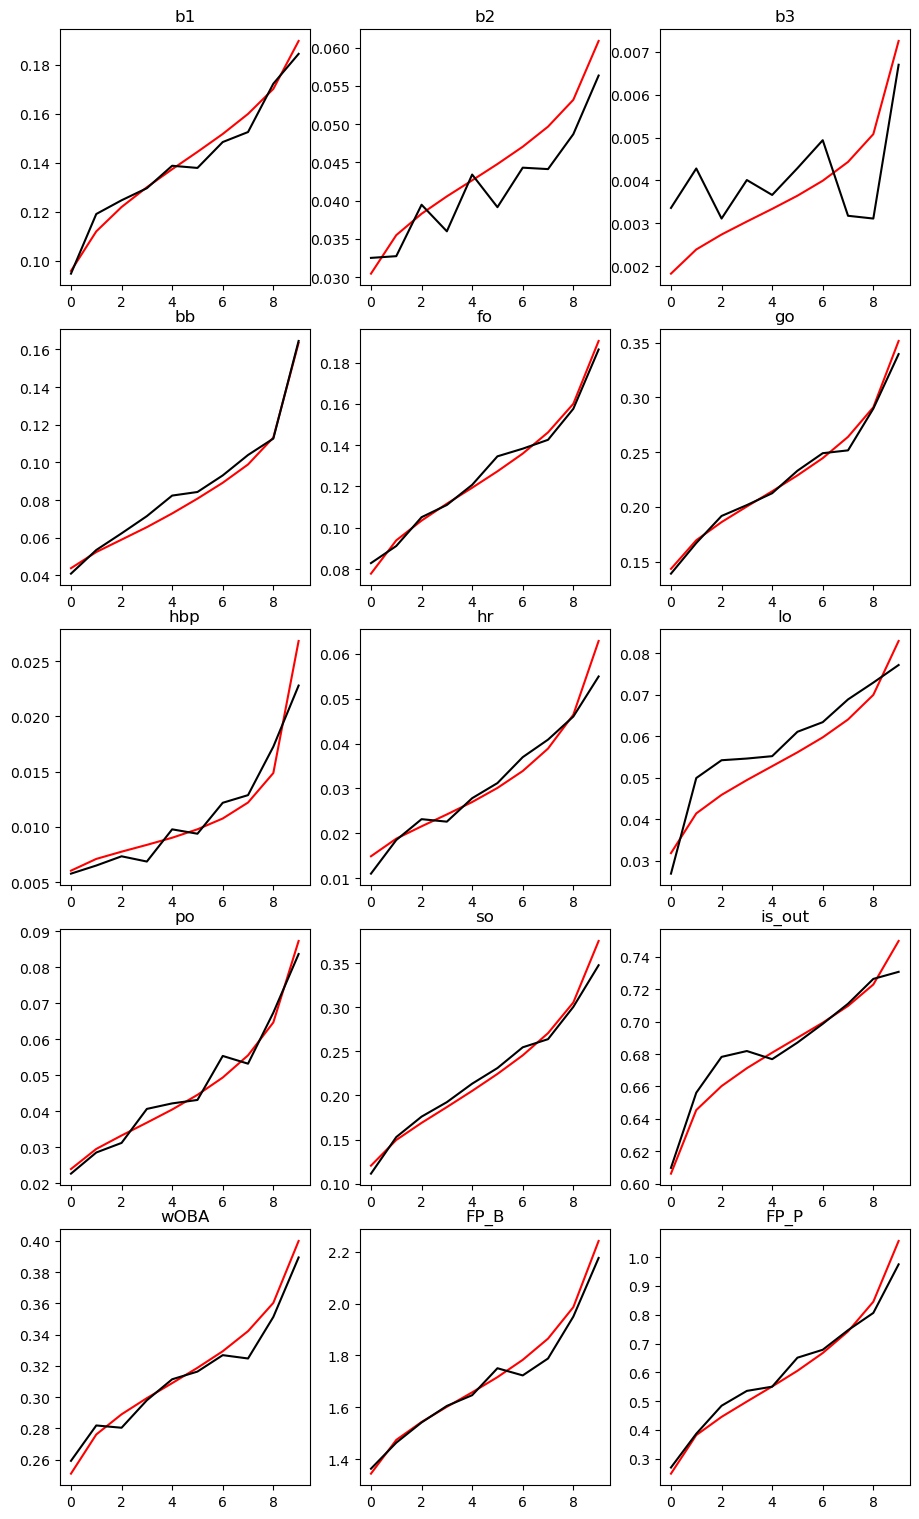

Model 1: predict_all_adjusted_16_93875_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.687643  0.654906   0.297116  0.303808 0.087951 0.087678   
         1         0.646257  0.616671   0.305651  0.310738 0.075003 0.074779   
1.000000 0         0.574285  0.635099   0.323658  0.303901 0.101786 0.102830   
         1         0.553146  0.498733   0.327386  0.329586 0.090236 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.131434 0.140161 0.041339 0.038934 0.003808 0.004047   
         1       0.136641 0.143146 0.045448 0.043099 0.004222 0.004216   
1.000000 0       0.135345 0.123585 0.044524 0.045283 0.004335 0.003302   
         1       0.135788 0.150585 0.047776 0.0467

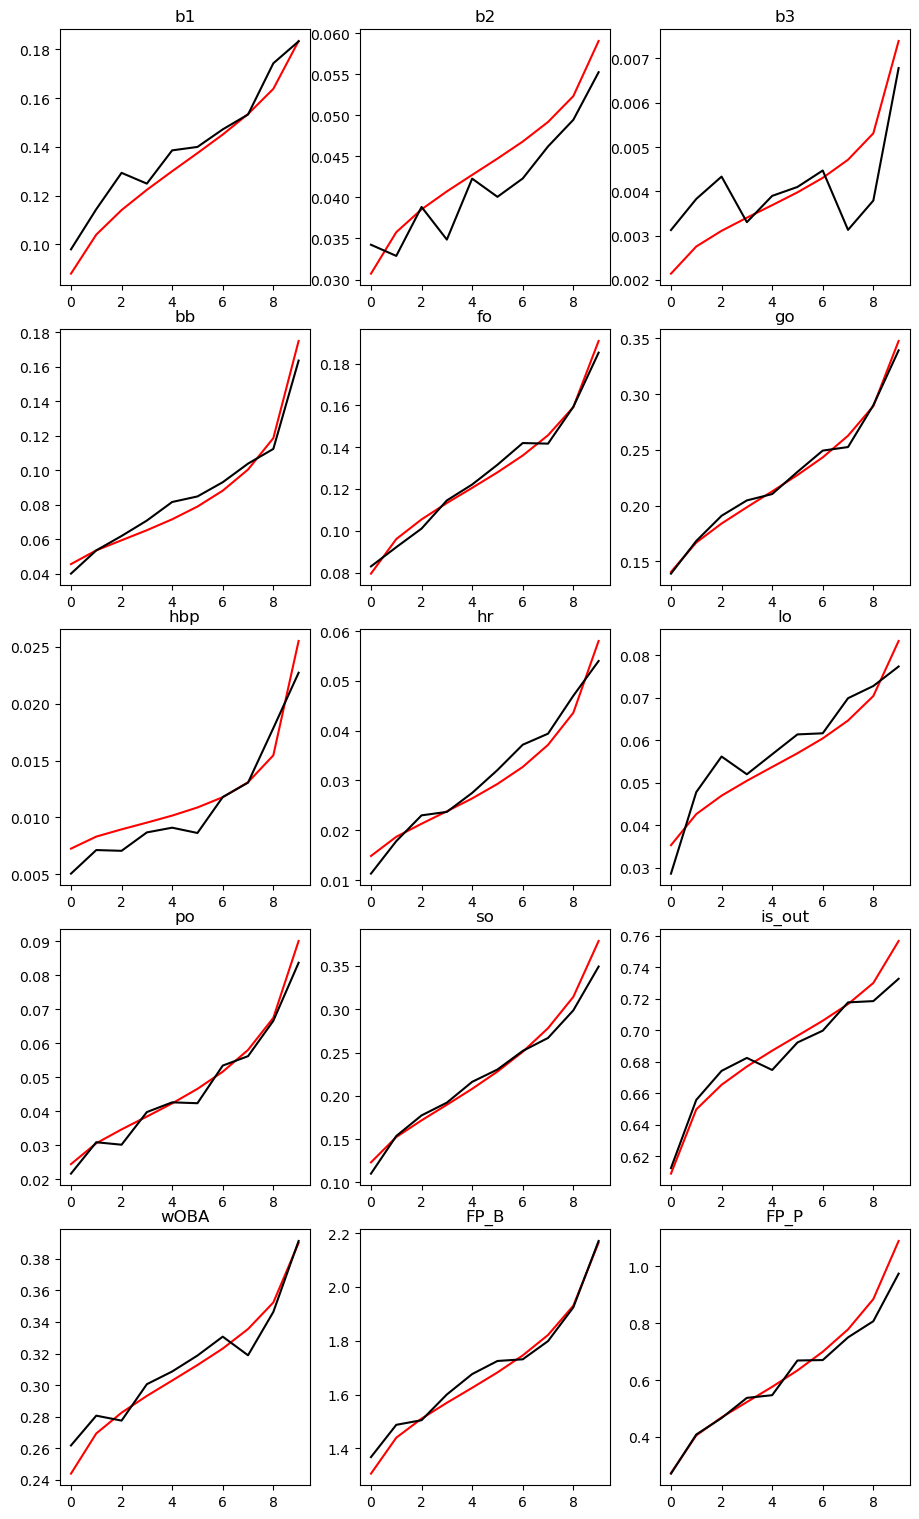

Model 2: predict_all_adjusted_16_93876_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.663334  0.654906   0.304704  0.303808 0.087175 0.087678   
         1         0.618720  0.616671   0.314909  0.310738 0.073522 0.074779   
1.000000 0         0.550615  0.635099   0.331591  0.303901 0.101179 0.102830   
         1         0.526167  0.498733   0.337318  0.329586 0.088880 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.136075 0.140161 0.041461 0.038934 0.003863 0.004047   
         1       0.141401 0.143146 0.045997 0.043099 0.004329 0.004216   
1.000000 0       0.139513 0.123585 0.044800 0.045283 0.004429 0.003302   
         1       0.140640 0.150585 0.048323 0.0467

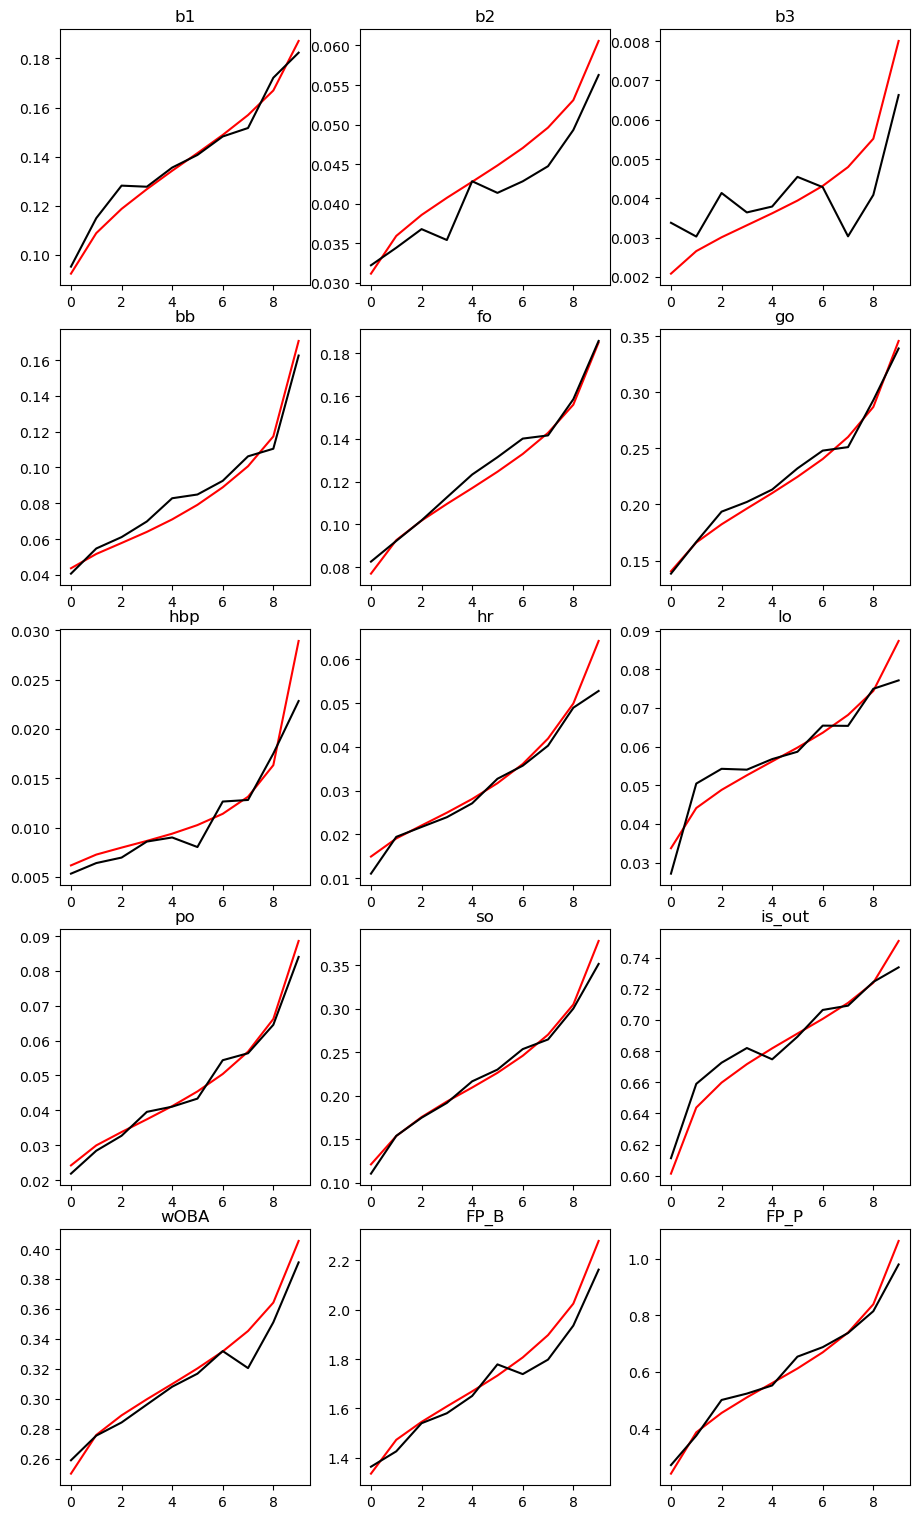

Model 3: predict_all_adjusted_16_93877_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.654835  0.654906   0.305586  0.303808 0.087364 0.087678   
         1         0.616474  0.616671   0.312342  0.310738 0.074997 0.074779   
1.000000 0         0.556233  0.635099   0.327456  0.303901 0.100994 0.102830   
         1         0.529594  0.498733   0.332478  0.329586 0.089587 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.139661 0.140161 0.041320 0.038934 0.003662 0.004047   
         1       0.145012 0.143146 0.044792 0.043099 0.003935 0.004216   
1.000000 0       0.141594 0.123585 0.043959 0.045283 0.004102 0.003302   
         1       0.143768 0.150585 0.046893 0.0467

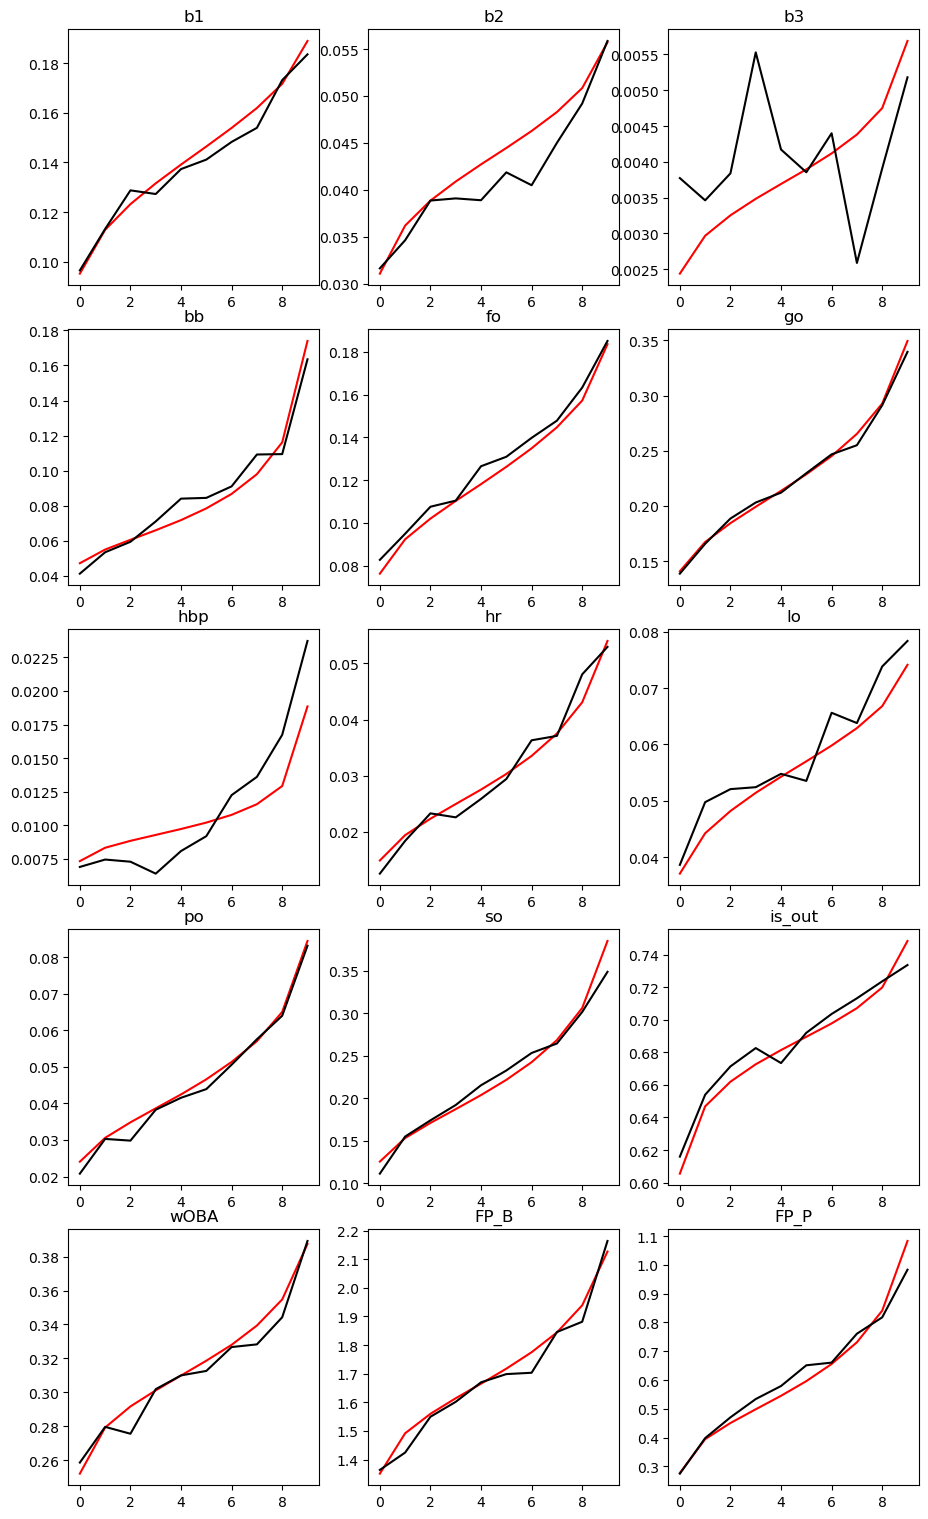

Model 4: predict_all_adjusted_16_93878_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.660139  0.654906   0.301842  0.303808 0.089350 0.087678   
         1         0.618227  0.616671   0.310806  0.310738 0.076149 0.074779   
1.000000 0         0.547903  0.635099   0.328521  0.303901 0.102564 0.102830   
         1         0.523775  0.498733   0.332984  0.329586 0.090658 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.137537 0.140161 0.040275 0.038934 0.003482 0.004047   
         1       0.142734 0.143146 0.044547 0.043099 0.003923 0.004216   
1.000000 0       0.140810 0.123585 0.043712 0.045283 0.003909 0.003302   
         1       0.142126 0.150585 0.047003 0.0467

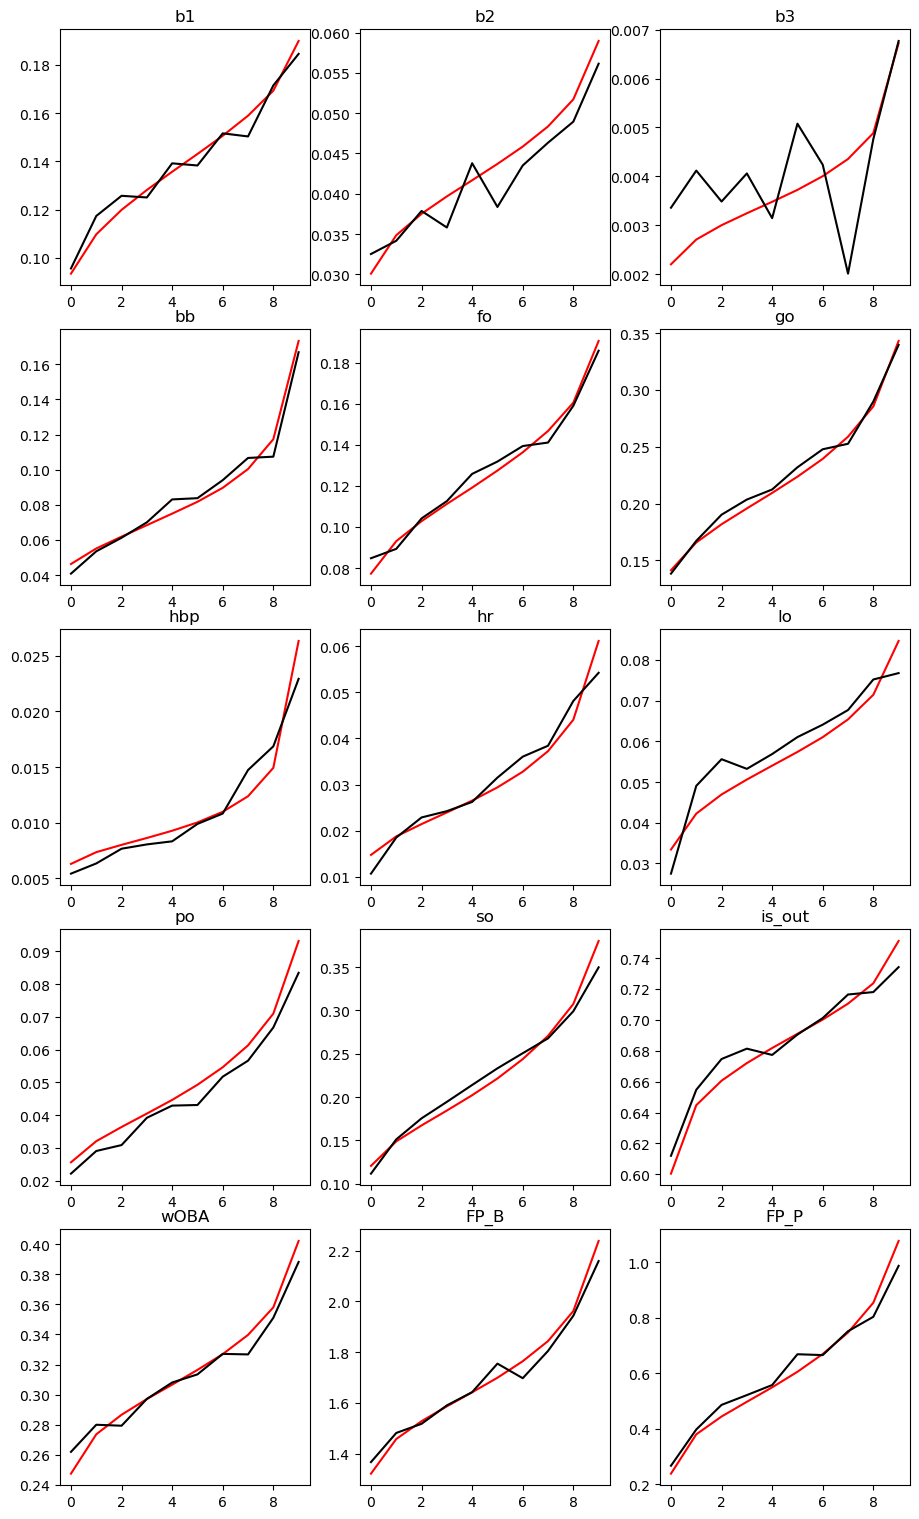

Model 5: predict_all_adjusted_16_93879_20250908.sav
Voting Classifier

Imputation Status x Starter
                  FP_P_pred  FP_P_act  wOBA_pred  wOBA_act  bb_pred   bb_act  \
imp_p    starter                                                               
0.000000 0         0.691211  0.654906   0.295573  0.303808 0.084789 0.087678   
         1         0.646640  0.616671   0.305142  0.310738 0.072363 0.074779   
1.000000 0         0.581714  0.635099   0.321611  0.303901 0.097851 0.102830   
         1         0.555493  0.498733   0.327017  0.329586 0.086460 0.091374   

                  b1_pred   b1_act  b2_pred   b2_act  b3_pred   b3_act  \
imp_p    starter                                                         
0.000000 0       0.135944 0.140161 0.039821 0.038934 0.003474 0.004047   
         1       0.141656 0.143146 0.044004 0.043099 0.003889 0.004216   
1.000000 0       0.139701 0.123585 0.043196 0.045283 0.004072 0.003302   
         1       0.141453 0.150585 0.046433 0.0467

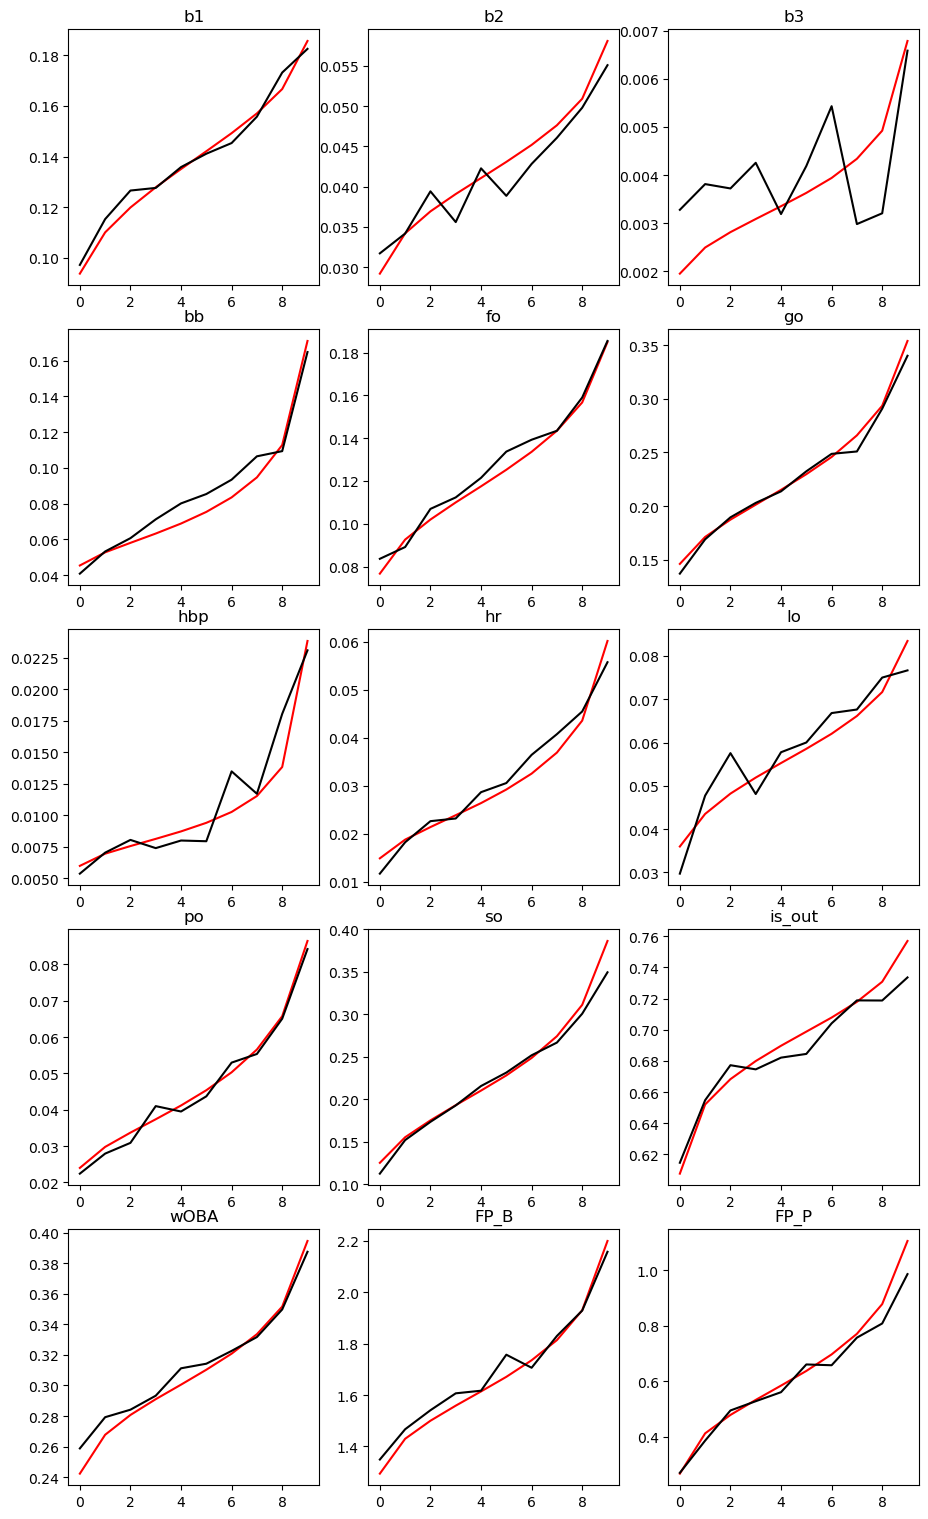

Model 6: predict_all_adjusted_16_93880_20250908.sav
Voting Classifier


In [ ]:
%%time
for i in range(num_models):
    # Set filename
    all_adjusted_filename = f"predict_all_adjusted_{''.join(str(x) for x in layers)}_{random_state+i}_{todaysdate}.sav"
    print(f"Model {i}: {all_adjusted_filename}")

    # Determine if voting
    if num_classifiers > 1:
        print("Voting Classifier")
        # Build list of MLP classifiers with varied random_state
        estimators = []
        for j in range(num_classifiers):
            clf = MLPClassifier(
                hidden_layer_sizes=layers,
                activation=activation,
                verbose=True,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                early_stopping=early_stopping,
                random_state=random_state + i + j * 100,
                max_iter=max_iter,
                tol=tol,
                n_iter_no_change=n_iter_no_change,
                batch_size=batch_size
            )
            estimators.append((f"mlp_{j}", clf))
        
        # Combine into a soft voting classifier
        predict_all_adjusted = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)    
    else:
        print("Single Classifier")
        # Create Model
        predict_all_adjusted = MLPClassifier(hidden_layer_sizes=layers, 
                                             activation=activation, 
                                             verbose=True, 
                                             alpha=alpha, 
                                             learning_rate_init=learning_rate_init, 
                                             early_stopping=early_stopping, 
                                             random_state=random_state+i, 
                                             max_iter=max_iter,
                                             tol=tol, 
                                             n_iter_no_change=n_iter_no_change,
                                             batch_size=batch_size, 
                                             validation_fraction=validation_fraction)


    # Fit
    predict_all_adjusted.fit(model_dataset[training_mask][all_adjusted_input_list], model_dataset[training_mask][['eventsModel']].values.ravel())

    # Save model
    pickle.dump(predict_all_adjusted, open(os.path.join(model_path, "M03. Plate Appearances", all_adjusted_filename), 'wb'))
    
    # Predict all types
    all_outputs = list(predict_all_adjusted.classes_)
    all_outputs_pred = [x + "_pred" for x in all_outputs]
    
    model_dataset.loc[~training_mask, all_outputs_pred] = predict_all_adjusted.predict_proba(model_dataset[~training_mask][all_adjusted_input_list])

    ### Constructed Stats
    model_dataset = constructed_stats(model_dataset)


    ### Summary Statistics
    print("\nImputation Status x Starter")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p', 'starter'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 
                                                                                             'bb_pred', 'bb_act',
                                                                                             'b1_pred', 'b1_act', 'b2_pred', 'b2_act', 'b3_pred', 'b3_act', 'hr_pred', 'hr_act', 
                                                                                             'so_pred', 'so_act' ]].mean())
    print("\nPitcher: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_p'])[['FP_P_pred', 'FP_P_act', 'wOBA_pred', 'wOBA_act', 'hr_pred', 'hr_act', 'so_pred', 'so_act']].mean())
    print("\nBatter: Imputation Status")
    print(model_dataset[~training_mask].query('year == 2024').groupby(['imp_b'])[['FP_B_pred', 'FP_B_act', 'wOBA_pred', 'wOBA_act', 'hr_pred', 'hr_act', 'so_pred', 'so_act']].mean())
    print("\nVenue")
    print(model_dataset[~training_mask].query('year == 2024').groupby('venue_id')[['FP_B_pred', 'FP_B_act', 'FP_P_pred', 'FP_P_act']].mean())
    print("\nHR Deciles")
    model_dataset['hr_wfx_quantile'] = pd.qcut(model_dataset['hr_wfx'], q=quantiles, labels=False) + 1
    print(model_dataset[~training_mask].groupby('hr_wfx_quantile')[['hr_pred', 'hr_act']].mean())
    print("\n")
    
    ### Quantiles
    # Loop over metrics
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:        
        # Calculate quantiles
        model_dataset.loc[~training_mask, f'{var}_quantile'] = pd.qcut(model_dataset.loc[~training_mask, f'{var}_pred'], quantiles, labels=False, duplicates='drop')
        
        # Create aggregated dataframe
        globals()[f"{var}_df"] = model_dataset.loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_year_df"] = model_dataset.query(f'year >= {year}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
        globals()[f"{var}_venue_df"] = model_dataset.query(f'venue_id == {venue}').loc[~training_mask].groupby(f'{var}_quantile')[[f'{var}_act', f'{var}_pred']].mean().reset_index()
    
    ### All Years
    all_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_df"]['se'] = (globals()[f"{var}_df"][f'{var}_act'] - globals()[f"{var}_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_df"]['se'].mean()
        all_df = pd.DataFrame(["All", var, actual, predicted, mult, stdev, mse])
        all_df_list.append(all_df)
    
    all_dfs = pd.concat(all_df_list, axis=1).T
    
    ### Specific Year
    recent_df_list = []
    for var in all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']:
        actual = model_dataset.query(f'year >= {year}').loc[~training_mask][f'{var}_act'].mean()
        predicted = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].mean()
        mult = actual/predicted
        stdev = model_dataset.query(f'year == {year}').loc[~training_mask][f'{var}_pred'].std()
        globals()[f"{var}_year_df"]['se'] = (globals()[f"{var}_year_df"][f'{var}_act'] - globals()[f"{var}_year_df"][f'{var}_pred']) ** 2
        mse = globals()[f"{var}_year_df"]['se'].mean()
        recent_df = pd.DataFrame([str(int(year)), var, actual, predicted, mult, stdev, mse])
        recent_df_list.append(recent_df)
    
    recent_dfs = pd.concat(recent_df_list, axis=1).T
    
    ### Outcome Summary
    all_stat_df = pd.concat([all_dfs, recent_dfs], axis=0).reset_index(drop=True)
    all_stat_df.columns = ['Year', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']
    all_stat_df['File'] = all_adjusted_filename
    all_stat_df['Layers'] = str(layers)
    all_stat_df['Models'] = num_models
    all_stat_df['State'] = random_state+i
    all_stat_df[['Year', 'File', 'Layers', 'Models', 'State', 'Output', 'Actual', 'Predicted', "Multiplier", 'Std. Dev', 'MSE']]

    print(all_stat_df[['Year', 'Output', 'Actual', 'Predicted', 'Multiplier', 'Std. Dev', 'MSE']])
    
    all_adjusted_stat_list.append(all_stat_df)


    
    ### Graphs
    graph_options = ["", "_year", "_venue"]
    graph_index = 1
    graph = graph_options[graph_index]
    print(f"Graphing {graph}")

    rows, columns = 5, 3
    fig, axs = plt.subplots(rows, columns, figsize=(9, 15))
    
    # Ensure that the number of plots doesn't exceed available subplots
    total_plots = rows * columns
    output_vars = all_outputs + ['is_out', 'wOBA', 'FP_B', 'FP_P']
    
    # Limit the number of plots to the available subplots
    output_vars = output_vars[:total_plots]
    
    for i, var in enumerate(output_vars):
        row = i // columns  # Calculate the row index based on the iteration
        col = i % columns   # Calculate the column index based on the iteration
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_pred'], color='red')
        axs[row, col].plot(globals()[f"{var}{graph}_df"][f'{var}_quantile'], globals()[f"{var}{graph}_df"][f'{var}_act'], color='black')
        axs[row, col].set_title(var)
    
    # Add some space between subplots to prevent overlapping
    fig.tight_layout(pad=.0)
    
    # Show the figure
    plt.show()


In [ ]:
all_adjusted_stat_df = pd.concat(all_adjusted_stat_list)
all_adjusted_stat_df = all_adjusted_stat_df.reset_index(drop=True)

In [ ]:
subset = all_adjusted_stat_df.query('Year == "2024"').query('Output == "wOBA"').query('1.01 > Multiplier > 0.99').reset_index(drop=True)
pareto_front = pareto_optimal(subset, ['MSE', 'Std. Dev'], ['Minimize', 'Maximize']).sort_values('Std. Dev')
pareto_front